## Comparative Analysis of Keras and PyTorch Model

1. Prepare data, load and evaluate Keras model.
2. Prepare data, load and evaluate PyTorch model.
3. Compute multiple performance metrics including accuracy, precision, recall and f1-score.
4. Visualize receiver operating characteristic (ROC) curves.

We will compare the performance of the Keras-based and the PyTorch based convolutional neural network (CNN) models using various evaluation metrics. 
- **Accuracy**: Measures how often the model is correct overall. A higer value mean more total predictions are correct.
- **Precision**: Measures how many predicted positives are actually correct. A higher value mean fewer false positives (incorrectly predicted positives).
- **Recall**: Measures how many real positives the model finds. A higher value means fewer false negatives (missed positive cases).
- **F1 Score**: Tells us about the balance between precision and recall. A higher value mean a better trade-off between precision and recall.
- **ROC-AUC**: Measures the model's ability to distinguish classes. A higher value reflects a model that can better distinguish between classes at all probability thresholds.

For all these metrics, the model should aim for values as close to 1.0 (100%) as possible. Lower values indicate poorer model performance. There are exceptions for some metrics in otehr settings (like various loss functions, where lower is better), but for these standard classification metrics, higher is always better.

#### Step 1: Library imports and setup

In [5]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os 
import time
import httpx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F


os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu
CPU times: total: 7.55 s
Wall time: 18.5 s


#### Step 2: Import the Evaluation Metrics

##### Evaluation Metrics 

The following metrics are used for evaluation of various AI/ML models:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
- Receiver Operating Characteristic - Area Under Curve (ROC-AUC)

##### 1. Accuracy

**Definition:**
Accuracy is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined. In other words, it measures how often the classifier is correct overall.

**Formula:**
\[
Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
\]

- TP: True positives (correctly predicted positive cases)
- TN: True negatives (correctly predicted negative cases)
- FP: False positives (incorrectly predicted positive cases)
- FN: False negatives (incorrectly predicted negative cases)

**Significance:**

Accuracy is intuitive and easy to interpret, making it a common first metric for model evaluation. However, it can be misleading if the dataset is imbalanced (i.e., one class is much more frequent than the other). This is because a model can achieve high accuracy by simply predicting the majority class.


##### 2. Precision

**Definition:**
Precision measures the proportion of positive predictions that are actually correct. It answers the question: "Of all the samples that the model predicted as positive, how many were truly positive?"

**Formula:**
\[
Precision = $\frac{TP}{TP + FP}$
\]

**Significance:**
Precision is crucial when the cost of a false positive is high. For example, in medical diagnosis, predicting a disease when it's not present (false positive) can lead to unnecessary treatments. In land classification, high precision means that when the model predicts a tile as agricultural, it is likely correct.


##### 3. Recall (sensitivity or true positive rate)

**Definition:**
Recall measures the proportion of actual positive cases that were correctly identified by the model. It answers: "Of all the true positive samples, how many did the model identify?"

**Formula:**
\[
Recall = $\frac{TP}{TP + FN}$
\]

**Significance:**
Recall is important when the cost of missing a positive case (false negative) is high. In land classification, high recall means the model is good at finding all the agricultural land, even if it sometimes mislabels non-agricultural land as agricultural.


##### 4. F1 score

**Definition:**
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It is especially useful when you need to find an equilibrium between precision and recall.

**Formula:**
\[
F1 = $2 \times \frac{Precision \times Recall}{Precision + Recall}$
\]

**Significance:**
The F1 score is especially valuable when the class distribution is uneven or when both false positives and false negatives are important. It penalizes extreme values, so a model with high precision but low recall (or vice versa) will have a lower F1 score.


##### 5. Confusion matrix

**Definition:**
A confusion matrix is a table that summarizes the performance of a classification algorithm. It displays the counts of true positives, false positives, true negatives, and false negatives.

|               | Predicted positive | Predicted negative |
|---------------|-------------------|-------------------|
| Actual positive | True positive (TP) | False negative (FN) |
| Actual negative | False positive (FP) | True negative (TN) |

**Significance:**
The confusion matrix provides a detailed breakdown of model errors and successes, helping you understand not just how often the model is right, but *how* it is wrong. This is crucial for diagnosing issues like class imbalance or systematic misclassification.


##### 6. ROC-AUC (Receiver operating characteristic - Area under curve)

**Definition:**
ROC-AUC measures the model's ability to distinguish between classes across all possible classification thresholds. The ROC curve plots the true positive rate (recall) against the false positive rate at various thresholds. The AUC (area under the curve) summarizes this performance in a single value between 0 and 1.

**Significance:**
A model with an ROC-AUC of 1.0 perfectly distinguishes between classes, while a value of 0.5 suggests random guessing. ROC-AUC is especially useful for imbalanced datasets and when you care about the ranking of predictions rather than their absolute values.


--

We will now define the functions to compute and print classification metrics including accuracy, precision, recall, F1 score, ROC-AUC, confusion matric, and log loss. These functions support both Keras and PyTorch model outputs.

In [6]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

In [7]:
# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Loss": log_loss(y_true, y_prob),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Confusion Matrix": confusion_matrix(y_true, y_pred),
        "Classification Report": classification_report(y_true, y_pred, target_names=class_labels, digits=4),
        "Class Labels": class_labels
    }
    return metrics

# function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report: \n\n {metrics["Classification Report"]}")
    print("======== Confusion Matrix ========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"], display_labels=metrics["Class Labels"])
    disp.plot()
    plt.show()

#### Step 3: Render Model

In [8]:
import os

data_dir = "."

keras_model_name = "ibm_ai_capstone_project.model.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_name = "0_ibm_ai_capstone_project.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

For downstream processing, we will now define:
1. The dataset directory path
2. Define image dimensions
3. Number of channels
4. Batch size
5. Numer of classes
6. Class labels

In [9]:
dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
num_classes = 2

agri_class_labels = ["non-agri", "agri"]

.\images_dataSAT


#### Step 4: Keras model evaluation and prediction

In this cell, we will: 
- Use `ImageDataGenerator` to rescale images.
- Load test images from the dataset directory.
- Load the saved Keras model using `tf.keras.models.load_model`.
- Run predictions on the test set, collect predicted probabilities, predicted classes, and true labels.

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle=True
)

keras_model = tf.keras.models.load_model(keras_model_path)

steps = int(np.ceil(prediction_generator.samples / prediction_generator.batch_size))
batch_size = int(prediction_generator.batch_size)
print(f"Number of Steps: {steps} with batch size: {batch_size}")

all_preds_keras = []
all_probs_keras = []
all_labels_keras = []

for step_idx, step in enumerate(tqdm(range(steps), desc="Steps")):
    images, labels = next(prediction_generator)
    preds = keras_model.predict(images, verbose="0")
    all_probs_keras.extend(preds) # basically append.
    preds = (preds > 0.5).astype(int).flatten()
    all_preds_keras.extend(preds) # basically append.
    all_labels_keras.extend(labels)

Found 6000 images belonging to 2 classes.
Number of Steps: 47 with batch size: 128


Steps: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]


Evaluation metrics for the Keras Model
Accuracy:  0.9945
ROC-AUC:   0.9999
Loss:      0.0136

Classification report: 

               precision    recall  f1-score   support

    non-agri     0.9907    0.9983    0.9945      3000
        agri     0.9983    0.9907    0.9945      3000

    accuracy                         0.9945      6000
   macro avg     0.9945    0.9945    0.9945      6000
weighted avg     0.9945    0.9945    0.9945      6000

======== Confusion Matrix ========


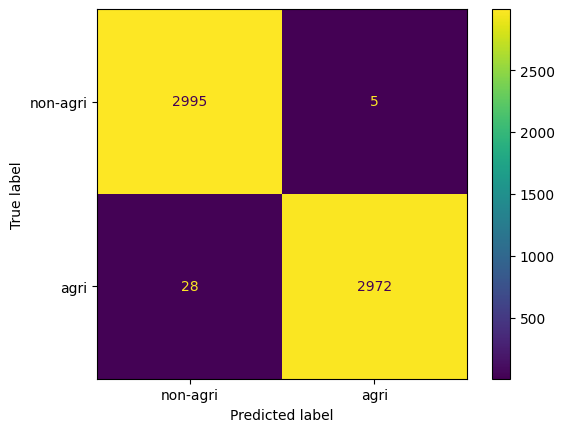

In [11]:
# Print the performance metrics for the Keras model using print_metrics functions.

print_metrics(
    y_true = all_labels_keras,
    y_pred = all_preds_keras,
    y_prob = all_probs_keras,
    class_labels = agri_class_labels,
    model_name = "Keras Model"
)

#### Step 5: PyTorch model evaluation and prediction

In this cell, we will:
- Set devide for inference (GPU if available).
- Define data transformations including resizing, normalization.
- Load the daaset using `ImageFolder` and prepared a DataLoader.
- Define the CNN architecture ,atching the saved state dict.
- Load model weights.
- Run inference on the test set, collecting predicted classes, probabilities, and true labels for metrics calculation.

This was the original plan...

*** In Keras:

When you run:
`keras_model = tf.keras.models.load_model("ibm_ai_capstone_project.model.keras")`

→ Keras automatically restores everything:
- The model architecture (layers, shapes, activations, etc.)
- The weights
- The optimizer (if it was saved)
- The training configuration (losses, metrics)
- That’s because Keras saves both structure + weights together in the .keras (or older .h5) format.

*** In PyTorch:

When you run: `model.load_state_dict(torch.load("ibm_ai_capstone_project.pth"))`


→ PyTorch only restores the weights (state_dict).
- It does not include:
- The model class definition (the architecture)
- The optimizer
- The loss function
- Any metadata about shapes or configuration

So, PyTorch assumes that you know what kind of model you trained.
When you call load_state_dict, it needs an existing instance of the same architecture to load weights into.

That’s why you must redefine your model class in code — it must exactly match what you trained before.

However, if we do not want to redefine the architecture every time, we could do:

Save the full model object instead of just the weights:

`torch.save(model, "ibm_ai_capstone_project_full.pth")`


Then later:

`model = torch.load("ibm_ai_capstone_project_full.pth", map_location=device)`

`model.eval()`

Hence, we will go back to our previous project and save the models as shown above, and skip redefining the architecture.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing inference on {device}")

Processing inference on cuda


In [13]:
# Load model
model = torch.load(pytorch_state_dict_name, weights_only=False)
model = model.to(device) # moves the model's weights to the same device (CPU or GPU) as your input data so they can communicate.
model.eval()

train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
        # for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Step: 100%|██████████| 47/47 [00:03<00:00, 12.54it/s]


In Keras, if you saved a model with model.save(), it included preprocessing information like normalization parameters, so you didn't have to redefine the transforms.

PyTorch doesn't have that built-in. When you save a model with torch.save(model, path), it only saves the architecture and weights—not the preprocessing steps or their parameters.

Evaluation metrics for the PyTorch Model
Accuracy:  0.9983
ROC-AUC:   1.0000
Loss:      0.0037

Classification report: 

               precision    recall  f1-score   support

    non-agri     0.9987    0.9980    0.9983      3000
        agri     0.9980    0.9987    0.9983      3000

    accuracy                         0.9983      6000
   macro avg     0.9983    0.9983    0.9983      6000
weighted avg     0.9983    0.9983    0.9983      6000

======== Confusion Matrix ========


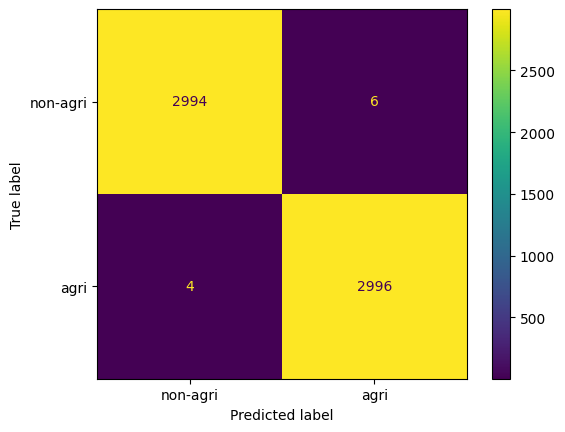

In [14]:
print_metrics(
    y_true = all_labels_pytorch,
    y_pred = all_preds_pytorch,
    y_prob = all_probs_pytorch,
    class_labels = agri_class_labels,
    model_name="PyTorch Model"
)

#### Step 6: ROC curve plotting

Begin by defining a function to plot ROC curves for binary or multi-class classification using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class cases by binarizing labels if needed.

Then, plot the ROC curves for both models.

In [17]:
def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

Plot the ROC curves for both Keras and PyTorch models on the same figure for visual performance comparison.

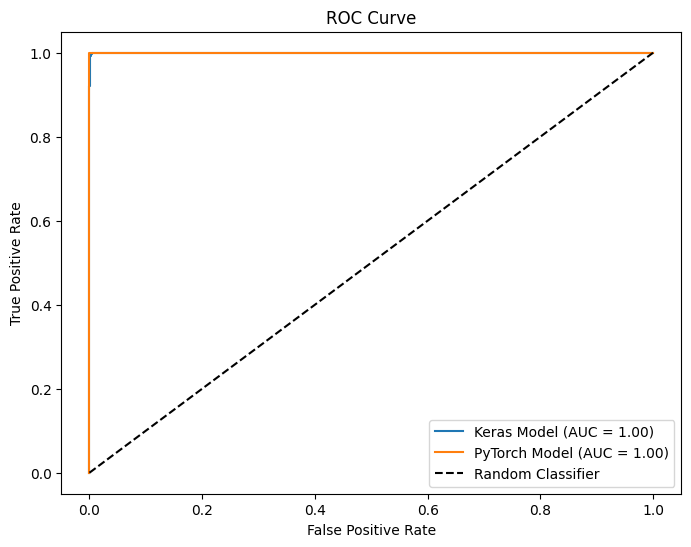

In [24]:
plt.figure(figsize=(8, 6))
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras), "Keras Model")
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # diagonal line
plt.legend()
plt.show()

#### Step 7: Comparing model performance

Now we will compare the performance of different models to understand which model would be the best performer for our land classification task.

In [25]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)

# Display the comparsion of metrics
print("{:<18} {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))

mertics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in mertics_list:
    print("{:<18} {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     Keras Model     PyTorch Model  
Accuracy   0.9945          0.9983         
Precision  0.9983          0.9980         
Recall     0.9907          0.9987         
F1 Score   0.9945          0.9983         
ROC-AUC    0.9999          1.0000         


`Accuracy`: Both models achieve exceptional accuracy, but the **PyTorch model makes fewer mistakes**. 

`Precision`: The Keras model performs better in **avoiding false positive**.

`Recall`: The PyTorch model is better at **identifying all true positives**, capturing neraly all actual positive cases, while the Keras model misses a few.

`F1 Score`: The F1 score, which balances precision and recall, favors the PyTorch model thanks to its **stronger recall**

`ROC-AUC`: Both models reach basically maximum possible **discrimination between classes**, indicating outstanding capability for binary classification.  

##### Model comparison: Key insights

**PyTorch model strengths**
- Achieves the highest scores in accuracy, recall, and F1, indicating extremely robust overall performance and near-perfect classification of positive cases.
- ROC-AUC of 1.0 shows perfect class seperability.

**Keras model strengths**
- Displays almost perfect precision every positive prediction made is correct.
- Also achieves near perfect ROC-AUC, indicating outstanding discrimination ability.

**Common strength**
- Both models deliver flawless ROC-AUC, suggesting both are highly effective for this classiciation task.

**Recommendations**
- The PyTorch model is preferable for applications where missing any positive instances is costly (higher recall).
- The Keras model is optimal for scenarios where making any false positive error is unacceptable (higher precsion).

**Next**
- Monitor real-world performances, as even marginal differences can become important in high-impact applications.

**Summary**:

Both models excel in all evaluated metrics and would be highly reliable in production. The PyTorch model demonstrated a modest edge in recall and F1 score, while the Keras model maximizes precision. The choice between models should ultimately reflect the specific requirements and risk tolerance of our use case.